In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.ensemble import AdaBoostClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
trin_ids = train.iloc[:,0]
train_x = train.iloc[:,1:-1]
train_y = train.loc[:,'y']
test_x = test.iloc[:,1:]

feature_names = ['x1','x2','x3','x4','x5']

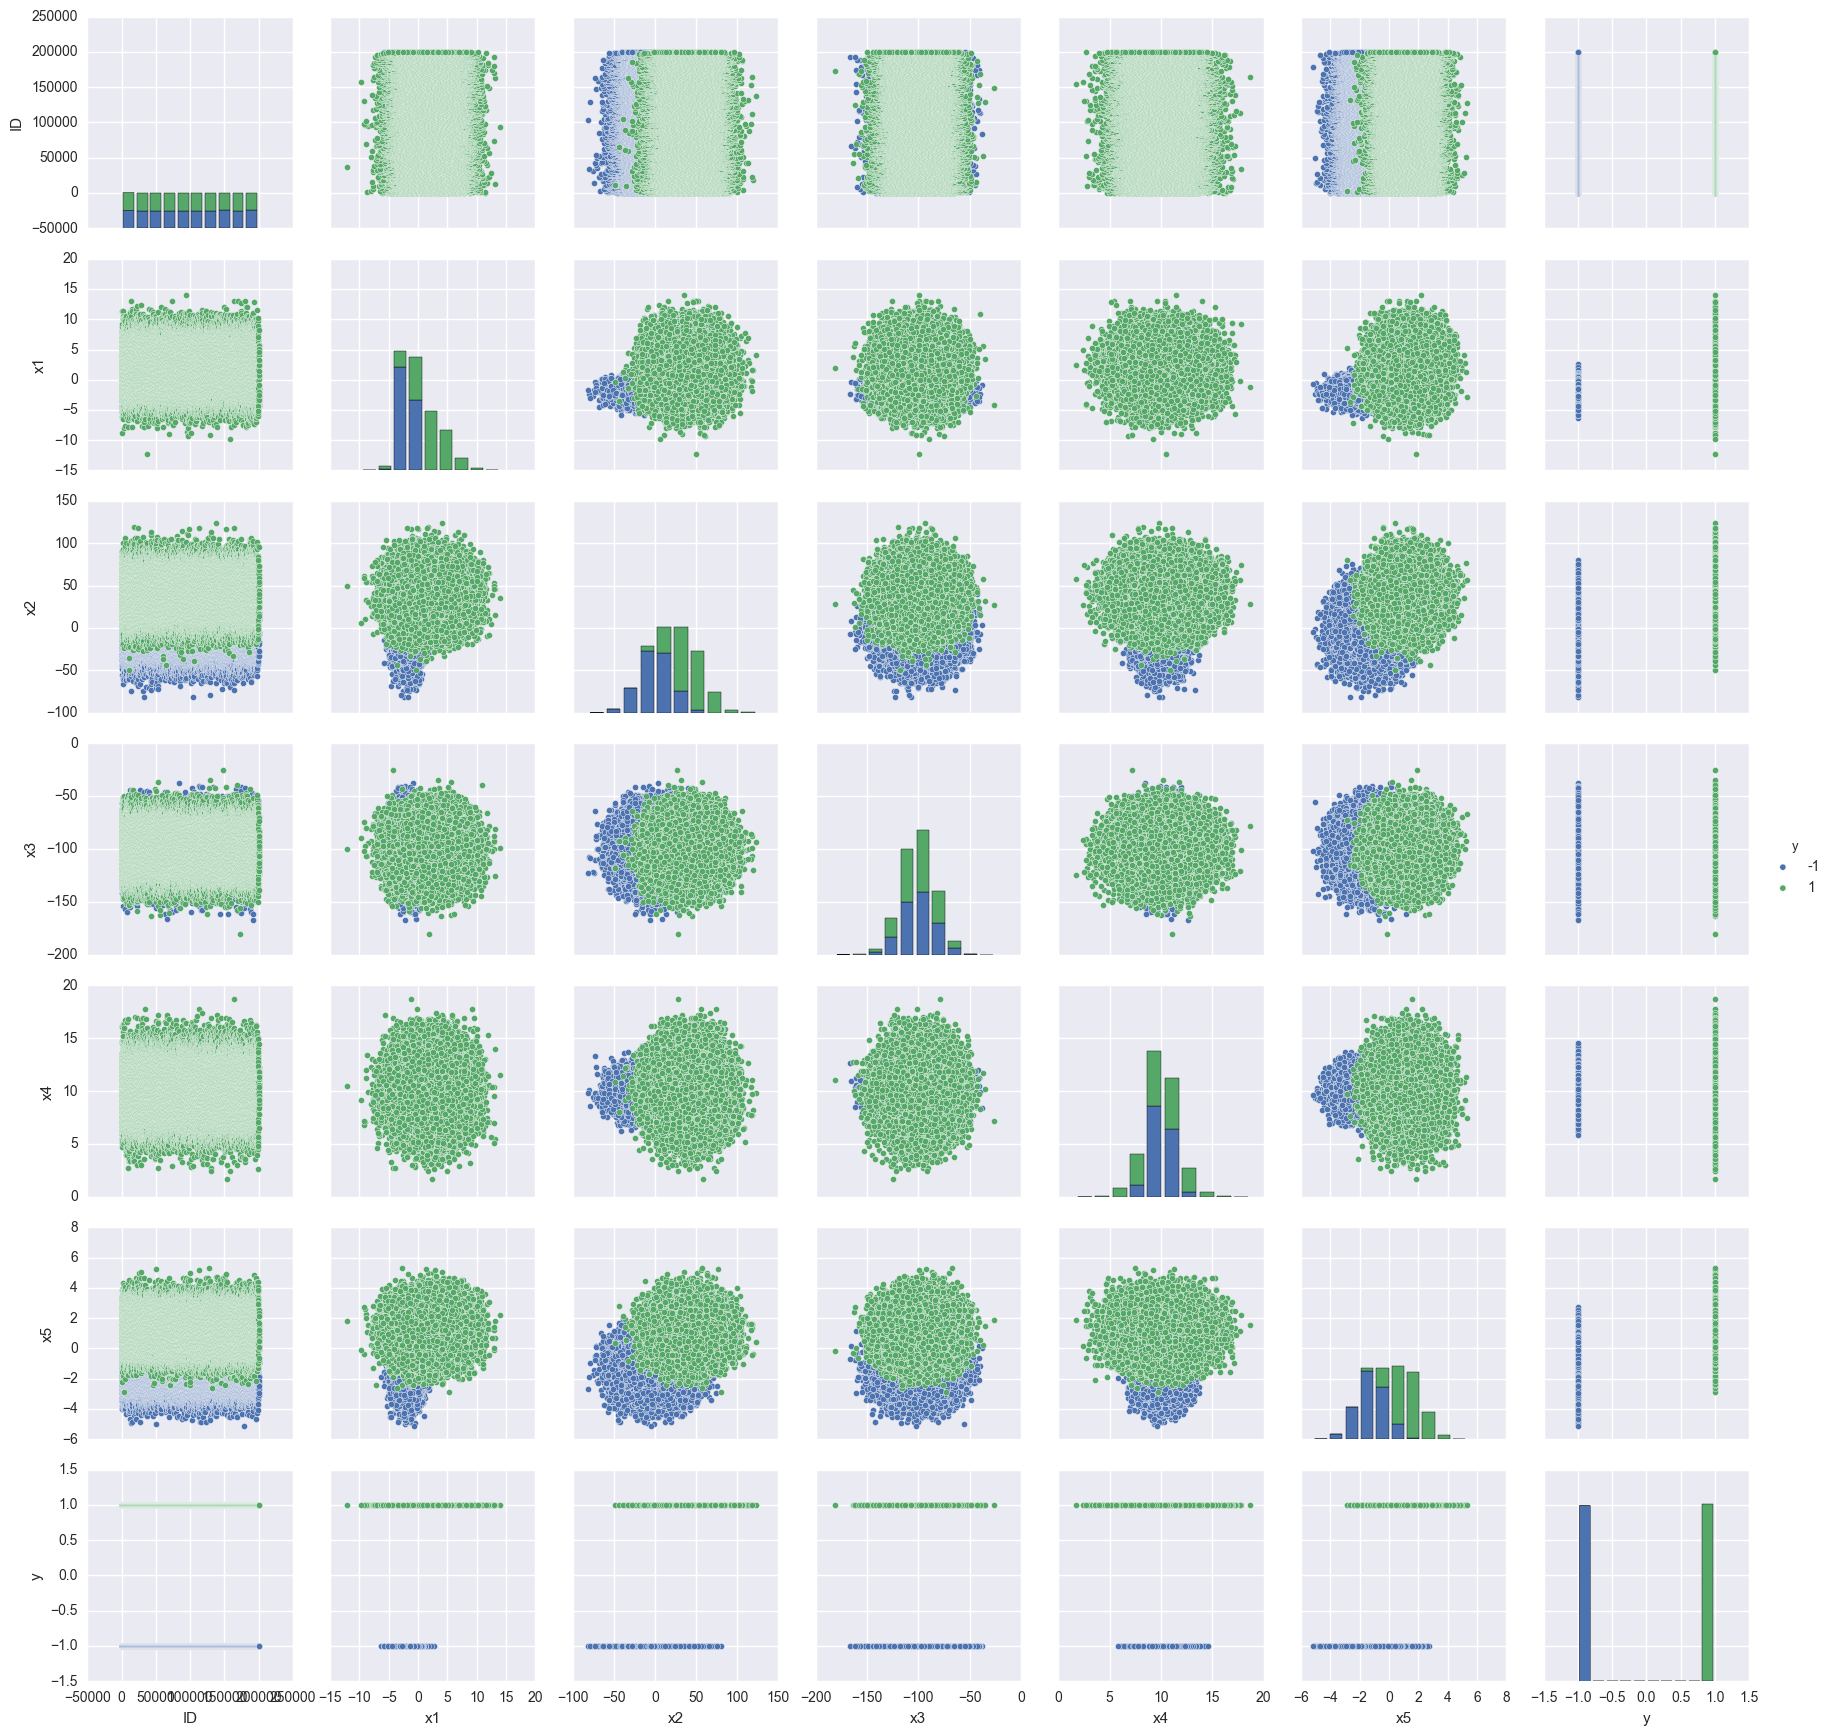

In [3]:
sns.pairplot(train, hue='y')
plt.show()

generated by gaussians except feature no 2 (maybe)

In [4]:
for f in feature_names:
    feature = train_x[f]
    u = np.unique(feature).shape
    print u

(100000L,)
(100000L,)
(100000L,)
(100000L,)
(100000L,)


The are continuous

In [7]:
#change -1 to 0
train_y.loc[train_y==-1] = 0

In [12]:
print np.mean(train_y)

0.50231


Classes are balanced, this is the score we can achieve by filling predict with constants

In [16]:
for f_name in feature_names:
    for label in [0,1]:
        feature = train_x.loc[train_y==label,f_name]
        print 'feature '+ f_name + ' label + ' + str(label) + ' ' + str(stats.shapiro(feature))

feature x1 label + 0 (0.999959409236908, 0.7905375361442566)
feature x1 label + 1 (0.9999303817749023, 0.23960775136947632)
feature x2 label + 0 (0.9999752640724182, 0.9853365421295166)
feature x2 label + 1 (0.9999793171882629, 0.9960997104644775)
feature x3 label + 0 (0.9999592304229736, 0.7870493531227112)
feature x3 label + 1 (0.9999563694000244, 0.7213020920753479)
feature x4 label + 0 (0.9999703168869019, 0.9531416296958923)
feature x4 label + 1 (0.9999653100967407, 0.8893434405326843)
feature x5 label + 0 (0.9999616742134094, 0.8325960040092468)
feature x5 label + 1 (0.9999562501907349, 0.7192462086677551)


p_value > 0.05, we cannot reject null hypothesis. (p-value might not be accurate)

Let's check the baselines

# RF

In [9]:
param_grid = {
#    'max_depth': [80, 90, 100, 110],
#    'max_features': [2, 3],
#    'min_samples_leaf': [3, 4, 5],
#    'min_samples_split': [8, 10, 12],
    'n_estimators': [150, 200, 300]
}

In [10]:
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 3)
grid_search.fit(train_x, train_y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   39.1s remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   50.1s remaining:   25.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [150, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [11]:
print grid_search.best_params_
print grid_search.best_score_

{'n_estimators': 300}
0.97524


The accuary for rf is 0.97524 with original features

# Adaboost

In [18]:
param_grid_ada = {
#    'max_depth': [80, 90, 100, 110],
#    'max_features': [2, 3],
#    'min_samples_leaf': [3, 4, 5],
#    'min_samples_split': [8, 10, 12],
    'n_estimators': range(45,55)
}

In [19]:
ada = AdaBoostClassifier()
grid_search_ada = GridSearchCV(estimator = ada, param_grid = param_grid_ada, 
                          cv = 3, n_jobs = -1, verbose = 3)
grid_search_ada.fit(train_x, train_y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed:   26.6s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   28.5s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [45, 46, 47, 48, 49, 50, 51, 52, 53, 54]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [20]:
print grid_search_ada.best_params_
print grid_search_ada.best_score_

{'n_estimators': 54}
0.97432


a bit worser then rf

# Features

we wiil try to craft new features knowing that this dataset was generate by gaussians

In [23]:
features_lda = []
for f in feature_names:
    clf = QuadraticDiscriminantAnalysis(store_covariance=True)
    clf.fit(train_x[f].values.reshape((-1,1)), train_y.values)

    features_lda.append(f+'_lda')
    pred = clf.predict_proba(train_x[f].values.reshape((-1,1)))
    train_x[f+'_lda']=pred[:,1]
    test_x[f+'_lda'] = clf.predict_proba(test_x[f].values.reshape((-1,1)))[:,1]

# RF + features

In [24]:
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 3)
grid_search.fit(train_x, train_y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   43.9s remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  1.0min remaining:   30.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [150, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [25]:
print grid_search.best_params_
print grid_search.best_score_

{'n_estimators': 300}
0.97562


# Adaboost + features

In [26]:
ada = AdaBoostClassifier()
grid_search_ada = GridSearchCV(estimator = ada, param_grid = param_grid_ada, 
                          cv = 3, n_jobs = -1, verbose = 3)
grid_search_ada.fit(train_x, train_y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed:   36.8s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   40.9s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [45, 46, 47, 48, 49, 50, 51, 52, 53, 54]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [27]:
print grid_search_ada.best_params_
print grid_search_ada.best_score_

{'n_estimators': 54}
0.97451


# RF only generated features

In [28]:
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 3)
grid_search.fit(train_x[features_lda], train_y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   30.0s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   43.4s remaining:   21.6s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [150, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [29]:
print grid_search.best_params_
print grid_search.best_score_

{'n_estimators': 200}
0.97557


# Adaboost only generated features

In [30]:
ada = AdaBoostClassifier()
grid_search_ada = GridSearchCV(estimator = ada, param_grid = param_grid_ada, 
                          cv = 3, n_jobs = -1, verbose = 3)
grid_search_ada.fit(train_x[features_lda], train_y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed:   24.4s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   25.9s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [45, 46, 47, 48, 49, 50, 51, 52, 53, 54]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [31]:
print grid_search_ada.best_params_
print grid_search_ada.best_score_

{'n_estimators': 53}
0.97456


# Naive bayes

In [32]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(train_x[features_lda], train_y)
print clf.score(train_x[features_lda], train_y)

0.96897


In [33]:
train_lda_x = train_x[features_lda]
test_lda_x = test_x[features_lda]

# Averaging

In [34]:
avg_pred = np.mean(train_lda_x.values,axis=1)
print np.mean((avg_pred>0.5)==train_y.values)

0.97089


# Logistic regression

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold

lr = LogisticRegression(fit_intercept=False)

cv = StratifiedKFold(n_splits=3, random_state=0)

scores=[]
for train_index, test_index in cv.split(train_lda_x, train_y):
    train_lda_x_, test_lda_x_ = train_lda_x.iloc[train_index,:], train_lda_x.iloc[test_index,:]
    train_lda_y_, test_lda_y_ = train_y.iloc[train_index], train_y.iloc[test_index]
    lr.fit(train_lda_x_, train_lda_y_)
    pred = lr.predict_proba(test_lda_x_)[:,1]
    scores.append(np.mean((pred > 0.5) == test_lda_y_))

print scores
print np.mean(scores)

[0.97216055678886426, 0.9717105657886842, 0.97290891635665422]
0.972260012978


In [65]:
lr.fit(train_lda_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [66]:
lr.coef_ 

array([[  6.62224715,   5.6957442 , -22.10405056,   4.6577519 ,
          6.51057556]])

In [67]:
lr.intercept_ 

0.0

# try xgb for better score

In [35]:
import xgboost as xgb

In [36]:
param_grid_xgb = {
#    'max_depth': [80, 90, 100, 110],
#    'max_features': [2, 3],
#    'min_samples_leaf': [3, 4, 5],
#    'min_samples_split': [8, 10, 12],
    'n_estimators': [50, 100, 200, 300, 400]
}

In [37]:
dtrain = xgb.DMatrix(train_x[features_lda], label=train_y)
dtest = xgb.DMatrix(train_x[features_lda])

In [38]:
%%time
param = {'max_depth':4, 'eta':0.01, 'silent':0,
         'objective':'binary:logistic',
         'subsample':0.8,
         'colsample_bytree':0.8,
         'seed':202,
         #'scale_pos_weight':scale_pos_weight
         #'updater':'grow_gpu'
        }
param['eval_metric'] = 'error'
trees = 2000
cv = xgb.cv(param, dtrain, metrics=('error'), show_stdv=True,
            num_boost_round=trees,nfold=3,early_stopping_rounds=50)

Wall time: 44.8 s


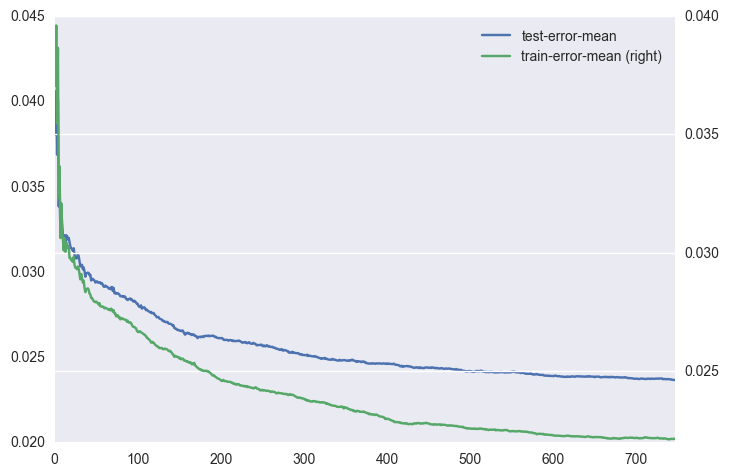

test-error-mean     0.023650
test-error-std      0.000283
train-error-mean    0.022155
train-error-std     0.000229
Name: 746, dtype: float64


In [41]:
cv[:].plot(y=['test-error-mean', 'train-error-mean'], secondary_y='train-error-mean')
plt.show()
print cv.loc[cv['test-error-mean'].argmin()]
trees = cv['test-error-mean'].argmin()

generated features gave us the best score on cv

we will build classifier using them: 
QDA + logistic regression on top